In [2]:
!pip install dash
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from dash import Dash, dcc, html
import plotly.express as px

In [35]:
df = pd.read_excel("Confectionary [4564].xlsx")

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1001 non-null   datetime64[ns]
 1   Country(UK)    1001 non-null   object        
 2   Confectionary  1001 non-null   object        
 3   Units Sold     996 non-null    float64       
 4   Cost(£)        992 non-null    float64       
 5   Profit(£)      998 non-null    float64       
 6   Revenue(£)     1001 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 54.9+ KB


In [37]:
df.isnull().sum()

Date             0
Country(UK)      0
Confectionary    0
Units Sold       5
Cost(£)          9
Profit(£)        3
Revenue(£)       0
dtype: int64

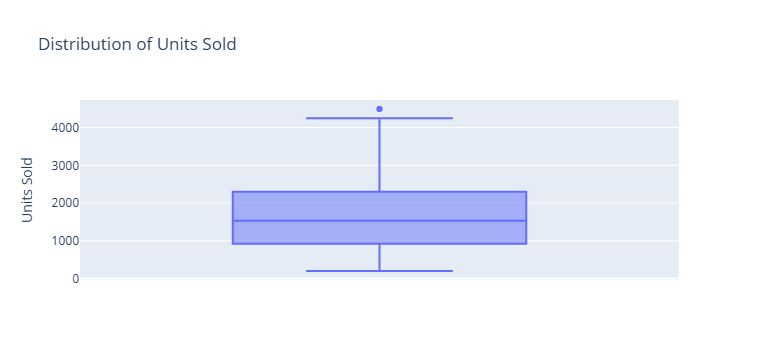

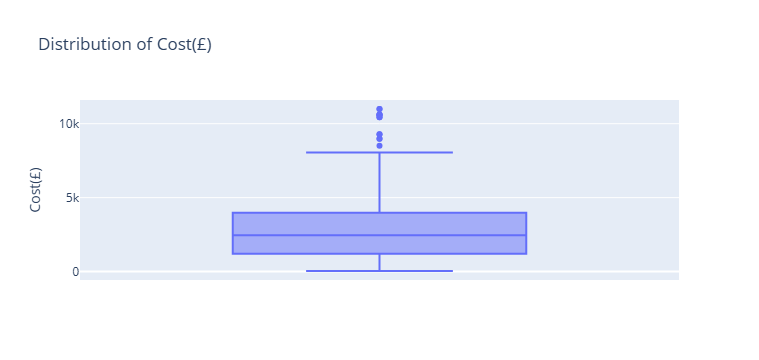

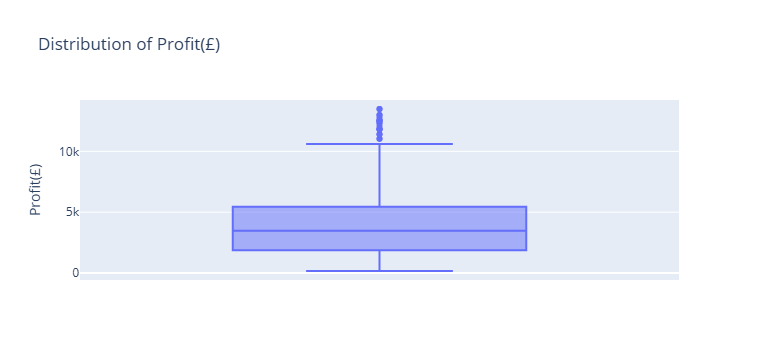

In [38]:
# Columns with numerical null values identified previously
columns_to_plot = ['Units Sold', 'Cost(£)', 'Profit(£)']

for col in columns_to_plot:
    fig = px.box(df, y=col, title=f'Distribution of {col}')
    fig.show()

In [39]:
# Calculate the median for 'Units Sold', 'Cost(£)', and 'Profit(£)'
median_units_sold = df['Units Sold'].median()
median_cost = df['Cost(£)'].median()
median_profit = df['Profit(£)'].median()

# Fill missing values with the calculated medians
df['Units Sold'] = df['Units Sold'].fillna(median_units_sold)
df['Cost(£)'] = df['Cost(£)'].fillna(median_cost)
df['Profit(£)'] = df['Profit(£)'].fillna(median_profit)

print(f"Missing values in 'Units Sold' filled with median: {median_units_sold}")
print(f"Missing values in 'Cost(£)' filled with median: {median_cost}")
print(f"Missing values in 'Profit(£)' filled with median: {median_profit}")

Missing values in 'Units Sold' filled with median: 1530.5
Missing values in 'Cost(£)' filled with median: 2456.8
Missing values in 'Profit(£)' filled with median: 3459.0


In [40]:
# Replace zero Revenue(£) with a small number to avoid division by zero
df['Revenue(£)_cleaned'] = df['Revenue(£)'].replace(0, np.finfo(float).eps)

# Calculate 'Profit Margin' using the cleaned Revenue(£)
df['Profit Margin'] = (df['Profit(£)'] / df['Revenue(£)_cleaned']) * 100

# Group by Country(UK) and calculate the average Profit Margin
average_profit_margin_by_country = df.groupby('Country(UK)')['Profit Margin'].mean().reset_index()

# Create an interactive bar chart
fig = px.bar(
    average_profit_margin_by_country,
    x='Country(UK)',
    y='Profit Margin',
    title='Average Profit Margin by Region',
    labels={'Country(UK)': 'Region', 'Profit Margin': 'Average Profit Margin (%)'},
    hover_data={'Profit Margin': ':.2f'},
    color='Country(UK)'
)

fig.update_layout(xaxis_title='Region', yaxis_title='Average Profit Margin (%)')
fig.show()

In [41]:
# Verify that missing values have been filled
df.isnull().sum()

Date                  0
Country(UK)           0
Confectionary         0
Units Sold            0
Cost(£)               0
Profit(£)             0
Revenue(£)            0
Revenue(£)_cleaned    0
Profit Margin         0
dtype: int64

In [42]:
# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with no date or region etc. (tweak as needed)
df = df.dropna(subset=['Date', 'Country(UK)', 'Confectionary'])

# Create 'Profit' if not already present
if 'Profit' not in df.columns:
    if {'Revenue(£)', 'Cost(£)'}.issubset(df.columns):
        df['Profit'] = df['Revenue(£)'] - df['Cost(£)']
    elif 'Profit(£)' in df.columns:
        df['Profit'] = df['Profit(£)']
    else:
        print("Warning: Could not create 'Profit' column as 'Revenue(£)', 'Cost(£)', or 'Profit(£)' not found.")
        df['Profit'] = np.nan

# Create 'ProfitMargin' if not already present
if 'ProfitMargin' not in df.columns:
    if 'Profit' in df.columns and 'Revenue(£)' in df.columns:
        df['ProfitMargin'] = np.where(df['Revenue(£)'] != 0,
                                      df['Profit'] / df['Revenue(£)'],
                                      np.nan)
    elif 'Profit(£)' in df.columns and 'Revenue(£)_cleaned' in df.columns:
        df['ProfitMargin'] = (df['Profit(£)'] / df['Revenue(£)_cleaned']) * 100
    else:
        print("Warning: Could not create 'ProfitMargin' column.")
        df['ProfitMargin'] = np.nan

# Extract time-based features for “which region peaks in sales from a time perspective”
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['MonthName'] = df['Date'].dt.month_name()

print(df.columns.tolist())

['Date', 'Country(UK)', 'Confectionary', 'Units Sold', 'Cost(£)', 'Profit(£)', 'Revenue(£)', 'Revenue(£)_cleaned', 'Profit Margin', 'Profit', 'ProfitMargin', 'Year', 'Month', 'MonthName']


In [43]:
# Average profit margin per confectionary and region
pmg = (
    df.groupby(['Confectionary', 'Country(UK)'], as_index=False)
      .agg(
          AvgProfitMargin=('ProfitMargin', 'mean'),
          TotalProfit=('Profit', 'sum'),
          TotalRevenue=('Revenue(£)', 'sum')
      )
)

print(pmg.head())

# Largest profit margin per confectionary (best region)
best_region = (
    pmg.sort_values(['Confectionary', 'AvgProfitMargin'], ascending=[True, False])
       .groupby('Confectionary')
       .head(1)
)

# Smallest profit margin per confectionary (worst region)
worst_region = (
    pmg.sort_values(['Confectionary', 'AvgProfitMargin'], ascending=[True, True])
       .groupby('Confectionary')
       .head(1)
)

print("Best region per confectionary:\n", best_region)
print("Worst region per confectionary:\n", worst_region)


  Confectionary Country(UK)  AvgProfitMargin  TotalProfit  TotalRevenue
0       Biscuit     England         0.997086   20935063.6    20971308.6
1       Biscuit      Jersey         0.996725   76753288.0    76874376.0
2       Biscuit  N. Ireland         0.996677   47118406.4    47215791.6
3       Biscuit    Scotland         0.998025   70392896.8    70514274.6
4       Biscuit       Wales         0.996385   65260590.4    65360716.8
Best region per confectionary:
       Confectionary Country(UK)  AvgProfitMargin   TotalProfit  TotalRevenue
3           Biscuit    Scotland         0.998025  7.039290e+07  7.051427e+07
8       Biscuit Nut    Scotland         0.998922  1.373929e+08  1.374775e+08
13          Caramel    Scotland         0.998510  2.544014e+08  2.546258e+08
17      Caramel Nut    Scotland         0.995883  7.298879e+06  7.376938e+06
22      Caramel nut    Scotland         0.995740  3.325428e+07  3.333233e+07
24   Choclate Chunk     England         0.998566  3.645382e+07  3.649195e+

In [44]:
# Monthly sales per region
monthly_region = (
    df.groupby(['Year', 'Month', 'Country(UK)'], as_index=False)
      .agg(
          TotalUnitsSold=('Units Sold', 'sum'),
          TotalRevenue=('Revenue(£)', 'sum')
      )
)

# For each region, find the month with max sales (using TotalRevenue as sales)
peak_per_region = (
    monthly_region.sort_values(['Country(UK)', 'TotalRevenue'], ascending=[True, False])
                  .groupby('Country(UK)')
                  .head(1)
)

print("Peak month per region:\n", peak_per_region)


Peak month per region:
      Year  Month Country(UK)  TotalUnitsSold  TotalRevenue
135  2002      5     England         15993.0    25838545.1
223  2003     12      Jersey         11121.0    37122090.5
243  2004      4  N. Ireland          9114.0    18808698.6
123  2002      2    Scotland         16035.0    43906650.6
236  2004      2       Wales          9942.0    22973221.1


In [45]:
# Using Plotly (interactive)
fig_pmg = px.bar(
    pmg,
    x="Confectionary",
    y="AvgProfitMargin",
    color="Country(UK)",
    barmode="group",
    title="Average Profit Margin by Confectionary and Region",
    labels={
        "AvgProfitMargin": "Average Profit Margin",
        "Confectionary": "Confectionary Type",
        "Country(UK)": "Region"
    }
)
fig_pmg.show()

In [46]:
# Aggregate by month (for smoother lines)
df_monthly = (
    df.groupby(['Year', 'Month', 'Country(UK)'], as_index=False)
      .agg(TotalSales=('Revenue(£)', 'sum'))
)

df_monthly['YearMonth'] = pd.to_datetime(df_monthly[['Year', 'Month']].assign(DAY=1))

fig_sales = px.line(
    df_monthly,
    x="YearMonth",
    y="TotalSales",
    color="Country(UK)",
    title="Monthly Sales by Region Over Time",
    labels={
        "YearMonth": "Date", 
        "TotalSales": "Total Sales",
        "Country(UK)": "Region"
    }
)
fig_sales.show()

In [47]:
pivot = pmg.pivot(index="Confectionary", columns="Country(UK)", values="AvgProfitMargin")

fig_heat = px.imshow(
    pivot,
    title="Average Profit Margin Heatmap (Confectionary vs Region)",
    labels=dict(x="Region", y="Confectionary", color="Avg Profit Margin")
)
fig_heat.show()

In [48]:
app = Dash(__name__)

# Example figure 1: profit margin by region
fig1 = fig_pmg     # from earlier
fig2 = fig_sales   # from earlier

app.layout = html.Div([
    html.H1("Confectionary Sales & Profit Dashboard"),

    html.Div([
        html.Label("Select Region:"),
        dcc.Dropdown(
            options=[{"label": r, "value": r} for r in df['Country(UK)'].unique()],
            value=None,
            id='region-filter',
            placeholder="All regions"
        )
    ]),

    dcc.Graph(id='profit-margin-chart', figure=fig1),
    dcc.Graph(id='sales-over-time-chart', figure=fig2)
])

if __name__ == "__main__":
    app.run(debug=True)

In [49]:
!pip install dash
from dash import Dash, dcc, html
import plotly.express as px

app = Dash(__name__)

# Example figure 1: profit margin by region
fig1 = fig_pmg     # from earlier
fig2 = fig_sales   # from earlier

app.layout = html.Div([
    html.H1("Confectionary Sales & Profit Dashboard"),

    html.Div([
        html.Label("Select Region:"),
        dcc.Dropdown(
            options=[{"label": r, "value": r} for r in df['Country(UK)'].unique()],
            value=None,
            id='region-filter',
            placeholder="All regions"
        )
    ]),

    dcc.Graph(id='profit-margin-chart', figure=fig1),
    dcc.Graph(id='sales-over-time-chart', figure=fig2)
])

if __name__ == "__main__":
    app.run(debug=True)

In [50]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

# ----------------------------------------
# IMPORTANT: Your dataset column is
# "Country(UK)" not "Region"
# ----------------------------------------

app = Dash(__name__)

# Example figure 1 (profit margin by region)
fig1 = fig_pmg        # must exist already
fig2 = fig_sales      # must exist already

# -------------------------
# APP LAYOUT
# -------------------------
app.layout = html.Div([
    html.H1("Confectionary Sales & Profit Dashboard"),

    html.Div([
        html.Label("Select Region:"),
        dcc.Dropdown(
            options=[{"label": r, "value": r} for r in df["Country(UK)"].unique()],
            value=None,
            id="region-filter",
            placeholder="All regions"
        )
    ]),

    dcc.Graph(id="profit-margin-chart", figure=fig1),
    dcc.Graph(id="sales-over-time-chart", figure=fig2),
])

# -------------------------
# CALLBACKS
# -------------------------
@app.callback(
    Output("profit-margin-chart", "figure"),
    Input("region-filter", "value")
)
def update_profit_chart(region):

    pmg = df.copy()

    if region:
        pmg = pmg[pmg["Country(UK)"] == region]

    pm_region = (
        pmg.groupby("Country(UK)")["Profit Margin"]
        .mean()
        .reset_index()
    )

    fig = px.bar(
        pm_region,
        x="Country(UK)",
        y="Profit Margin",
        title=f"Average Profit Margin ({region if region else 'All Regions'})"
    )

    return fig


@app.callback(
    Output("sales-over-time-chart", "figure"),
    Input("region-filter", "value")
)
def update_sales_chart(region):

    sales = df.copy()

    if region:
        sales = sales[sales["Country(UK)"] == region]

    line_df = (
        sales.groupby(["YearMonth", "Country(UK)"])["Revenue(£)"]
        .sum()
        .reset_index()
    )

    fig = px.line(
        line_df,
        x="YearMonth",
        y="Revenue(£)",
        color="Country(UK)",
        title=f"Sales Over Time ({region if region else 'All Regions'})"
    )

    fig.update_layout(xaxis_tickangle=45)

    return fig

# -------------------------
# RUN SERVER
# -------------------------
if __name__ == "__main__":
    app.run(debug=True)
